In [681]:
import pandas as pd 
import numpy as np 

import os
import re
import time

import matplotlib.pyplot as plt
import seaborn as sns

### Задание 1

Опишите задачу с точки зрения NLP. Что это за задача, какие классические методы существуют для ее решения? Как ее можно решать через LLM? Как обычно оценивают качество моделей в этой задаче?

Перед нами стоит задача NER (Named Entity Recognition). Эта задача заключается в идентификации определнных сущностей в тексте и их  классификации. Класификация предполагает отнесение найденных сущностей к одной из заранее известных категорий. В нашей задаче мы рассматриваем 5 классов: PER (человек), ORG (организация), LOC (место), EVT (мероприятие), PRO (продукт).

**Классические методы решения задачи NER:**

- Поиск по определенным правилам.

Этот метод предполагает распознавание именованных сущностей по заранее запрограмированным правилам. Например, можно использовать регулярные выражения для поиска определенных паттернов. Этот метод может быть полезн для распозавания дат, денежных сумм, чисел. Еще при поиске "по правилам" можно использовать словари или заранее созданные базы данных с интересующими сущностями. Такой метод лучше всего работает, если нам заранее известна предметная область и если мы ищем конкретные сущности (например, если задача заключается в поиске стран и городов в географическом справочнике).

- Использование машинного обучения

Если размеченных данных достаточно, то этот метод работает эффективно. При использовании такого метода большая часть времени уходит на инжиниринг признаков. Для обучения моделей может понадобиться информация о регистре слов, контексте, частях речи и т. д. После извлечения признаков переходят к обучению моделей (например, SVM или дерево решений)

- Использование глубокого обучения

В этот метод входит и решение с использованием LLM. Главное преимущество глубокого обучения перед классическим машинным обучением - автоматическое изучение признаков. То есть подготовка данных для обучения DL моделей менее трудоемкая. Однако для обучения нейронных сетей нужен достаточно большой объем данных. Для решения с помощью LLM можно создать промпт. В промпте можно указать формат вывода данных, а также несколько примеров. Кроме того, можно использовать гибридный метод, совместив LLM с традиционными решениями.  

Для оценки качества модели обычно используют следующие метрики:

$$Precision = \frac{TP}{TP + FP}$$

$$Recall = \frac{TP}{TP + FN}$$

$$F1 = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$$

где $TP$ - количество правильно предсказанных именованных сущностей, $FP$ - количество неправильно классифицированных именованных сущностей, $FN$ - ложно отрицательный класс. То есть $(TP + FN)$ - общее количество настоящих сущностей в документе, а $(TP + FP)$ - все сущности, предсказанные моделью

### Задание 2

Реализуйте чтение датасета в pandas DataFrame с обязательными колонками "document_id", "document_text", "entity", "gold_answer". Выведите шапку датафрейма.

In [682]:
path_to_raw = 'sample_pl_cs_ru_bg/raw/ru/'

document_id = []
raw_txt = []

for file in os.listdir(path_to_raw):
    with open(path_to_raw + file, 'r', encoding='utf-8') as f_raw:
        all_text = re.split(r'\n+', f_raw.read())
        document_id.append(all_text[0])
        raw_txt.append('\n'.join(all_text[4:]))

df_raw = pd.DataFrame({'document_id': document_id, 'document_text': raw_txt})
df_raw.head()

,document_id,document_text
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...
1,ru-1006,Захарова лирически прокомментировала отставку ...
2,ru-1004,Борис Джонсон ушел в отставку с поста главы МИ...
3,ru-1011,За Борисом Джонсоном последует сама Мэй - брит...
4,ru-1001,Глава МИД Британии Борис Джонсон подал в отста...


In [683]:
path_to_annotated = 'sample_pl_cs_ru_bg/annotated/ru/'

document_id = []
entity = []
gold_answer = []

df_ann = pd.DataFrame(columns=['document_id', 'entity', 'gold_answer'])

for file in os.listdir(path_to_annotated):
    with open(path_to_annotated + file, 'r', encoding='utf-8') as f_ann:
        all_text = f_ann.read().split('\n')

        all_entities = [tuple(re.split(r'\t', ent)) for ent in all_text[1:-1]]
        all_gold_answers = '; '.join([f'[{ent[0]}|{ent[2]}]' for ent in all_entities])

        document_id.append(all_text[0])
        entity.append(all_entities)
        gold_answer.append(all_gold_answers)


df_ann = pd.DataFrame({'document_id': document_id, 'entity': entity, 'gold_answer': gold_answer})
df_ann.head()

,document_id,entity,gold_answer
0,ru-10,"[(Brexit, Brexit, EVT, EVT-Brexit), (Альбиона,...",[Brexit|EVT]; [Альбиона|LOC]; [Альбионе|LOC]; ...
1,ru-1006,"[(Brexit, Brexit, EVT, EVT-Brexit), (Facebook,...",[Brexit|EVT]; [Facebook|PRO]; [Борис Джонсон|P...
2,ru-1011,"[(Brexit, Brexit, EVT, EVT-Brexit), (The Guard...",[Brexit|EVT]; [The Guardian|PRO]; [Борис Джонс...
3,ru-1004,"[(Brexit, , EVT, EVT-Brexit), (Борис Джонсон, ...",[Brexit|EVT]; [Борис Джонсон|PER]; [Германии|L...
4,ru-1000,"[(Brexit, Brexit, EVT, EVT-Brexit), (The Guard...",[Brexit|EVT]; [The Guardian|PRO]; [Борис Джонс...


In [684]:
df = df_raw.merge(df_ann)
df.head()

,document_id,document_text,entity,gold_answer
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,"[(Brexit, Brexit, EVT, EVT-Brexit), (Альбиона,...",[Brexit|EVT]; [Альбиона|LOC]; [Альбионе|LOC]; ...
1,ru-1006,Захарова лирически прокомментировала отставку ...,"[(Brexit, Brexit, EVT, EVT-Brexit), (Facebook,...",[Brexit|EVT]; [Facebook|PRO]; [Борис Джонсон|P...
2,ru-1004,Борис Джонсон ушел в отставку с поста главы МИ...,"[(Brexit, , EVT, EVT-Brexit), (Борис Джонсон, ...",[Brexit|EVT]; [Борис Джонсон|PER]; [Германии|L...
3,ru-1011,За Борисом Джонсоном последует сама Мэй - брит...,"[(Brexit, Brexit, EVT, EVT-Brexit), (The Guard...",[Brexit|EVT]; [The Guardian|PRO]; [Борис Джонс...
4,ru-1001,Глава МИД Британии Борис Джонсон подал в отста...,"[(Associated Press, , ORG, ORG-The-Associated-...",[Associated Press|ORG]; [Brexit|EVT]; [Борис Д...


### Задание 3

Напишите функцию, которая принимает на вход строку датафрейма и выдает текст входного сообщения для LLM.

In [685]:
def create_prompt(row):
    text = row['document_text']

    prompt = """
Выпиши все именованные сущности, сохраняя исходные формы слов, в которых они появляются в тексте ниже. Используй следующий формат вывода: [позиция_в_тексте|сущность|ТИП]; [позиция_в_тексте|сущность|ТИП]; ...

Возможные типы сущностей:

PER (люди): имена людей без титулов, фамилии
ORG (организации): государственные и негосудартвенные учреждения, компании, политические партии, музыкальные группы, спортивные команды и другие
LOC (места): все топонимы, объекты и сооружения
EVT (мероприятия): названия всех мероприятий, фестивалей, праздников, сражений, войн, техногенных катастроф и другие
PRO (продукты): бренды, названия продуктов, товаров, книг, фильмов, телепередач, компьютерных программ, произведений искусств, документов и другие

Текст: \n
    """

    return prompt + text

In [686]:
print(create_prompt(df.loc[8]))


Выпиши все именованные сущности, сохраняя исходные формы слов, в которых они появляются в тексте ниже. Используй следующий формат вывода: [позиция_в_тексте|сущность|ТИП]; [позиция_в_тексте|сущность|ТИП]; ...

Возможные типы сущностей:

PER (люди): имена людей без титулов, фамилии
ORG (организации): государственные и негосудартвенные учреждения, компании, политические партии, музыкальные группы, спортивные команды и другие
LOC (места): все топонимы, объекты и сооружения
EVT (мероприятия): названия всех мероприятий, фестивалей, праздников, сражений, войн, техногенных катастроф и другие
PRO (продукты): бренды, названия продуктов, товаров, книг, фильмов, телепередач, компьютерных программ, произведений искусств, документов и другие

Текст: 

    09.07.2018 17:02 : Министр иностранных дел Великобритании Борис Джонсон покинул свой пост
Об этом сообщает агентство Рейтер. Сегодня премьер Тереза Мэй приняла отставку. О преемнике будет объявлено позже. Мэй поблагодарила Джонсона за работу, — го

### Задание 4

Получите ответы GigaChat для всех документов. Документов всего 9, поэтому сделать это можно вручную, пользуясь веб-интерфейсом GigaChat или ботом в ВК или Телеграме. Не очищайте историю сообщений, чтобы потом продемонстрировать подлинность ответов на онлайн-собеседовании.

Внесите ответы GigaChat в датафрейм, сохраните его.

In [687]:
predicted ={'ru-10': 
                '[1|Тереза Мэй|PER]; [8|Brexit|EVT]; [46|СМИ|ORG]; [84|сентября|LOC]; [91|партии тори|ORG]; [101|Мэй|PER]; [128|Борис Джонсон|PER]; [143|министр иностранных дел Британии|ORG]; [159|Лондон|LOC]; [167|британская конституция|PRO]; [187|Мишель Барнье|PER]; [206|Брюссель|LOC]; [214|"брекзит"|EVT]; [253|Альбион|LOC]; [314|Европы|LOC]; [322|Лондон|LOC]; [330|Брюссель|LOC]; [344|ЕС|ORG]; [353|Северную Ирландию|LOC]; [367|таможенный союз единой Европы|ORG]; [371|единой Европы|LOC]; [394|Джонсона|PER]; [406|Великобритания|LOC]; [418|Евросоюз|ORG]; [433|страны|LOC]; [454|территории|LOC]; [468|Соединенное Королевство|LOC]; [532|европейские законы|PRO]; [563|Джонсон|PER]; [580|колонией|LOC]; [603|Европы|LOC]; [630|саммит|EVT]; [639|Европейский союз|ORG]; [649|Брюссель|LOC]; [673|Джонсоном|PER]; [682|Альбион|LOC]; [726|экстренного саммита Европейского союза|EVT]; [743|Австрия|LOC]; [754|канцлер Себастьян Курц|PER]; [770|брекзит|EVT]; [793|ЕС|ORG]; [806|Европейский союз|ORG]; [816|Лондоном|LOC]; [846|бывший министр иностранных дел|ORG]; [858|пост премьера|ORG]; [881|Ла-Манш|LOC]; [903|Международный валютный фонд|ORG]; [929|Лондон|LOC]; [943|Европейский союз|ORG]; [967|Европейскому парламенту|ORG]; [984|британскому парламенту|ORG]; [1016|лейбористы|ORG]; [1032|Брюссель|LOC]; [1045|Мэй|PER]; [1062|часть консерваторов|ORG]; [1078|Евросоюз|ORG]; [1094|британском парламенте|ORG]; [1115|экономическое|PRO]; [1125|политическое|PRO]; [1134|будущее|PRO]; [1136|Альбион|LOC]; [1169|бизнес|ORG]; [1183|лекарственные препараты|PRO]; [1199|Еврокомиссия|ORG]; [1223|финансовых рынках|LOC]; [1240|Европейской|LOC]; [1249|британским парламентом|ORG]; [1267|Евросоюз|ORG]; [1284|Альбион|LOC]', 
            'ru-1006': 
                '[0|Захарова|PER]; [34|МИД России|ORG]; [51|Мария Захарова|PER]; [84|Facebook|ORG]; [107|министра иностранных дел Великобритании|ORG]; [134|Борис Джонсон|PER]; [151|Захарова|PER]; [254|Т. Мэй|PER]; [315|Захаровой|PER]; [322|Британии|LOC]; [376|Борис Джонсон|PER]; [389|Мэй|PER]; [415|Brexit|EVT]', 
            'ru-1004': 
                '[0|Борис Джонсон|PER]; [3|МИД Великобритании|ORG]; [15|Борис Джонсон|PER]; [33|ТАСС|ORG]; [54|канцелярия премьер-министра|ORG]; [76|страны|LOC]; [85|Терезы Мэй|PER]; [134|Мэй|PER]; [142|Джонсона|PER]; [162|министр по вопросам Brexit|ORG]; [177|Дэвид Дэвис|PER]; [212|Мэй|PER]; [242|ЕС|ORG]; [246|Brexit|EVT]; [256|Дэвис|PER]; [266|ЕС|ORG]; [300|Джонсон|PER]; [308|премьера|PER]; [351|МИД|ORG]; [385|Германия|LOC]; [392|Польша|LOC]; [404|Лондоне|LOC]; [411|саммите|EVT]; [432|региона Западных Балкан|LOC]; [460|Джонсон|PER]; [490|министра иностранных дел|ORG]; [517|Консервативной партии|ORG]; [538|Мэй|PER]; [565|партичного руководителя|ORG]; [584|премьер-министра|ORG]', 
            'ru-1011': 
                '[3|Борисом Джонсоном|PER]; [11|Мэй|PER]; [36|министра иностранных дел Великобритании|ORG]; [61|Бориса Джонсона|PER]; [83|премьер-министра Великобритании|ORG]; [108|Терезы Мэй|PER]; [125|ЕС|ORG]; [174|Джонсона|PER]; [210|Великобритании|LOC]; [227|Терезы Мэй|PER]; [252|The Guardian|ORG]; [274|Brexit|EVT]; [314|Борис Джонсон|PER]; [333|Терезу Мэй|PER]; [350|британские СМИ|ORG]; [387|министра по выходу Великобритании из ЕС|ORG]; [403|Дэвид Дэвис|PER]; [422|Палату общин|ORG]; [453|кабинетом министров|ORG]; [478|страны|LOC]; [496|Евросоюза|ORG]; [512|разногласия Мэй|PER]; [516|Дэвисом|PER]; [522|Джонсоном|PER]; [550|ЕС|ORG]; [581|Великобританией|LOC]; [616|два ключевых министра|ORG]; [652|ЕС|ORG]; [688|Великобритании|LOC]; [699|ЕС|ORG]; [732|Великобритании|LOC]; [750|ЕС|ORG]; [784|Великобритании|LOC]; [798|ЕС|ORG]; [822|Великобритании|LOC]; [845|29 марта|DATE]; [856|ES|ORG]', 
            'ru-1001': 
                '[6|МИД Британии|ORG]; [18|Борис Джонсон|PER]; [36|министр иностранных дел Великобритании|ORG]; [54|Борис Джонсон|PER]; [75|Associated Press|ORG]; [99|премьер-министр|ORG]; [113|Тереза Мэй|PER]; [126|Джонсона|PER]; [137|Бориса|PER]; [171|канцелярии премьера|ORG]; [210|Мэй|PER]; [221|Джонсона|PER]; [267|Евросоюза|ORG]; [302|Жесткого Brexit|EVT]; [318|Мэй|PER]; [345|ЕС|ORG]; [369|Соединенного Королевства|LOC]; [386|Евросоюза|ORG]',
            'ru-1000': 
                '[14|ua|ORG]; [36|Борис Джонсон|PER]; [71|Джонсон|PER]; [116|Великобритании|LOC]; [160|Великобритании|LOC]; [178|Дэвид Дэвис|PER]; [207|Стив Бейкер|PER]; [230|Великобритании|LOC]; [246|Тереза Мэй|PER]; [266|МИД|ORG]; [283|Соединенного Королевства|LOC]; [298|Бориса Джонсона|PER]; [316|ЕС|ORG]; [341|The Guardian|ORG]; [356|УНН|ORG]; [372|премьер-министр|ORG]; [387|Бориса Джонсона|PER]; [420|министра иностранных дел|ORG]; [463|пресс-секретарь британского парламента|ORG]',
            'ru-1002': 
                '[0|09.07.2018 18:09|DATE]; [46|Великобритании|LOC]; [62|Тереза Мей|PER]; [88|министра иностранных дел|ORG]; [108|Борис Джонсон|PER]; [127|Великобритании|LOC]; [139|ЕС|ORG]; [166|Великобритании|LOC]; [183|Евросоюза|ORG]; [214|Великобритании|LOC]; [228|«Брекзит»|EVT]; [243|Дэвид Дэвис|PER]',
            'ru-1017': 
                '[0|Борис Джонсон|PER]; [41|Киев|LOC]; [53|9 июля|DATE]; [59|УНН|ORG]; [71|Борис Джонсон|PER]; [102|Великобритании|LOC]; [127|The Guardian|ORG]; [142|УНН|ORG]; [168|премьер-министр|ORG]; [183|Бориса Джонсона|PER]; [216|министра иностранных дел|ORG]; [259|пресс-секретарь британского парламента|ORG]; [312|Джонсон|PER]; [337|Великобритании|LOC]; [353|Дэвид Дэвис|PER]; [379|заместитель министра|ORG]; [394|Brexit|EVT]; [405|Стив Бейкер|PER]; [432|Великобритании|LOC]; [448|Тереза Мэй|PER]; [474|МИД|ORG]; [487|Соединенного Королевства|LOC]; [498|Бориса Джонсона|PER]; [516|ЕС|ORG]',
            'ru-1003': 
                '[0|09.07.2018 17:02|DATE]; [36|министр иностранных дел Великобритании|ORG]; [64|Борис Джонсон|PER]; [84|агентство Рейтер|ORG]; [100|премьер|ORG]; [108|Тереза Мэй|PER]; [123|Даунинг-Стрит|LOC]; [152|Борис Джонсон|PER]; [189|Великобритании|LOC]; [201|Евросоюза|ORG]; [235|министр по вопросам брекзита|ORG]; [251|Дэвид Дэвис|PER]'}

predicted = {k: re.sub(r'(\[)\d+\|', r'\1', v) for k, v in predicted.items()}
predicted = {k: '; '.join(sorted(set(v.split('; ')))) for k, v in predicted.items()}
df_predicted = pd.DataFrame({'document_id': predicted.keys(), 'pred': predicted.values()})
df = df.merge(df_predicted)
df

,document_id,document_text,entity,gold_answer,pred
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,"[(Brexit, Brexit, EVT, EVT-Brexit), (Альбиона,...",[Brexit|EVT]; [Альбиона|LOC]; [Альбионе|LOC]; ...,"[""брекзит""|EVT]; [Brexit|EVT]; [Австрия|LOC]; ..."
1,ru-1006,Захарова лирически прокомментировала отставку ...,"[(Brexit, Brexit, EVT, EVT-Brexit), (Facebook,...",[Brexit|EVT]; [Facebook|PRO]; [Борис Джонсон|P...,[Brexit|EVT]; [Facebook|ORG]; [Борис Джонсон|P...
2,ru-1004,Борис Джонсон ушел в отставку с поста главы МИ...,"[(Brexit, , EVT, EVT-Brexit), (Борис Джонсон, ...",[Brexit|EVT]; [Борис Джонсон|PER]; [Германии|L...,[Brexit|EVT]; [Борис Джонсон|PER]; [Германия|L...
3,ru-1011,За Борисом Джонсоном последует сама Мэй - брит...,"[(Brexit, Brexit, EVT, EVT-Brexit), (The Guard...",[Brexit|EVT]; [The Guardian|PRO]; [Борис Джонс...,[29 марта|DATE]; [Brexit|EVT]; [ES|ORG]; [The ...
4,ru-1001,Глава МИД Британии Борис Джонсон подал в отста...,"[(Associated Press, , ORG, ORG-The-Associated-...",[Associated Press|ORG]; [Brexit|EVT]; [Борис Д...,[Associated Press|ORG]; [Борис Джонсон|PER]; [...
5,ru-1000,Подробности.ua: Третий за сутки: Борис Джонсон...,"[(Brexit, Brexit, EVT, EVT-Brexit), (The Guard...",[Brexit|EVT]; [The Guardian|PRO]; [Борис Джонс...,[The Guardian|ORG]; [ua|ORG]; [Борис Джонсон|P...
6,ru-1002,09.07.2018 18:09 : Премьер-министр Великобрита...,"[(Бориса Джонсона, Борис Джонсон, PER, PER-Bor...",[Бориса Джонсона|PER]; [Брекзит|EVT]; [Великоб...,[09.07.2018 18:09|DATE]; [«Брекзит»|EVT]; [Бор...
7,ru-1017,Борис Джонсон подал в отставку с поста министр...,"[(Brexit, Brexit, EVT, EVT-Brexit), (The Guard...",[Brexit|EVT]; [The Guardian|PRO]; [Борис Джонс...,[9 июля|DATE]; [Brexit|EVT]; [The Guardian|ORG...
8,ru-1003,09.07.2018 17:02 : Министр иностранных дел Вел...,"[(Борис Джонсон, Борис Джонсон, PER, PER-Boris...",[Борис Джонсон|PER]; [Великобритании|LOC]; [Да...,[09.07.2018 17:02|DATE]; [Борис Джонсон|PER]; ...


In [688]:
df.to_csv('brexit_ru_df.csv')

### Задание 5 

Реализуйте самостоятельно алгоритм для подсчета метрик score_fn(gold: str, pred: str) → float. Можно пользоваться только библиотеками numpy, scipy, pandas. Напишите юнит-тесты. Возможно ли ускорить вычисление функции через векторную реализацию? Поясните решение и обоснуйте, почему выбрали именно такую метрику.

In [520]:
def precision_recall(gold: str, pred: str) -> float:
    """Расчет метрик precision и recall

    Args:
        gold (str): строка с верной классификацией сущностей из документа в формате [сущность|ТИП]; [сущность|ТИП]; ...
        pred (str): строка с предсказанной классификацией сущностей в формате [сущность|ТИП]; [сущность|ТИП]; ...

    Returns:
        float, float: precision, recall
    """
    gold_set = set(gold.split('; '))
    pred_set = set(pred.split('; '))

    n_gold = len(gold_set)
    n_pred = len(pred_set)

    n_true_positive = len(gold_set & pred_set)

    p = n_true_positive / n_pred if n_pred != 0 else 0
    r = n_true_positive / n_gold if n_gold != 0 else 0
    return p, r


def score_fn(gold: str, pred: str) -> float:
    """Расчет F1-метрики 

    Args:
        gold (str): строка с верной классификацией сущностей из документа в формате [сущность|ТИП]; [сущность|ТИП]; ...
        pred (str): строка с предсказанной классификацией сущностей в формате [сущность|ТИП]; [сущность|ТИП]; ...

    Returns:
        float: F1-score
    """
    p, r = precision_recall(gold, pred)
    f1_score = 2 * p * r / (p + r) if p + r != 0 else 0
    return f1_score

precision_recall - это вспомогательная функция, которая нужна для расчета метрик percision и recall. А итоговая функция score_fn расчитывает F1-score как среднее гармоническое percision и recall. Была выбрана именно F1 метрика, так как она дает наиболее полное представление о качестве модели.

Precision (точность распознавания) рассчитывается как отношение правильно предсказанных сущностей к общему количеству предсказанных сущностей. 

$$Precision = \frac{TP}{TP + FP}$$

Мы не можем опираться только на precision, так как она не учитывает ложно отрицательные ответы. То есть, например, если в тексте 10 сущностей типа LOC, а модель нашла и верно распознала только 3 такие сущности, то precision будет равен 1, но это не значит, что модель работает без ошибок.

Recall (полнота) рассчитывается как отношение правильно предсказанных к общему количеству сущностей. То есть recall показывает, сколько правильных ответов было распозно, но recall, не учитывает ложные срабатывания (FP). То есть recall тоже не дает полного представление о качестве модели

$$Recall = \frac{TP}{TP + FN}$$

In [521]:
def test(res, expected_res):
    if abs(res - expected_res) < 1e-6:
        print(f'CORRECT: {round(res, 3)} = {round(expected_res, 3)}')
    else:
        print(f'FAIL: {round(res, 3)} != {round(expected_res, 3)}')
    print('======================')

In [633]:
gold_test1 = '[Москва|LOC]; [Санкт-Петербург|LOC]; [Казань|LOC]'
gold_test2 = ''

pred_test = ['[Москва|LOC]; [Санкт-Петербург|LOC]; [Казань|LOC]',
             '[Москва|LOC]; [Санкт-Петербург|LOC]',
             '[Москва|LOC]; [Санкт-Петербург|LOC]; [Казань|LOC]; [слон|LOC]',
             '[Москва|LOC]; [Санкт-Петербург|LOC]; [слон|LOC]',
             '[Москва|LOC]',
             '[слон|LOC]; [самовар|LOC]; [воробей|LOC]',
             '']

expected_res1 = [1, 
                2 * 1 * (2 / 3) / (1 + 2 / 3), 
                2 * 1 * (3 / 4) / (1 + 3 / 4), 
                2 * (2 / 3) * (2 / 3) / (2 / 3 + 2 / 3), 
                2 * 1 * (1 / 3) / (1 + 1 / 3), 
                0, 
                0]

expected_res2 = [0, 0, 0, 0, 0, 0, 1]

for i in range(len(pred_test)):
    print(f'TEST {i + 1}')
    test(score_fn(gold_test1, pred_test[i]), expected_res1[i])

for i in range(len(pred_test)):
    print(f'TEST {len(pred_test) + i + 1}')
    test(score_fn(gold_test2, pred_test[i]), expected_res2[i])

TEST 1
CORRECT: 1.0 = 1
TEST 2
CORRECT: 0.8 = 0.8
TEST 3
CORRECT: 0.857 = 0.857
TEST 4
CORRECT: 0.667 = 0.667
TEST 5
CORRECT: 0.5 = 0.5
TEST 6
CORRECT: 0 = 0
TEST 7
CORRECT: 0 = 0
TEST 8
CORRECT: 0 = 0
TEST 9
CORRECT: 0 = 0
TEST 10
CORRECT: 0 = 0
TEST 11
CORRECT: 0 = 0
TEST 12
CORRECT: 0 = 0
TEST 13
CORRECT: 0 = 0
TEST 14
CORRECT: 1.0 = 1


Попробуем создать векторизованные функции с помощью np.vectorize и метода apply

In [680]:
vectorized_score_fn1 = np.vectorize(score_fn)


def vectorized_score_fn2(gold, pred):
    df = pd.DataFrame({'gold': gold.apply(lambda x: set(x.split('; '))), 'pred': pred.apply(lambda x: set(x.split('; ')))})

    n_gold = df.apply(lambda row: len(row['gold']), axis=1)
    n_pred = df.apply(lambda row: len(row['pred']), axis=1)

    n_true_positive = df.apply(lambda row: len(row.gold & row.pred), axis=1)

    p = n_true_positive / n_pred
    r = n_true_positive / n_gold

    f1_score = 2 * p * r / (p + r)
    return f1_score.fillna(0)


start = time.time()
vectorized1_res = vectorized_score_fn1(pd.Series([gold_test1] * len(pred_test)), pd.Series(pred_test))
stop = time.time()
time_vectorized1 = stop - start

start = time.time()
vectorized2_res = vectorized_score_fn2(pd.Series([gold_test1] * len(pred_test)), pd.Series(pred_test))
stop = time.time()
time_vectorized2 = stop - start

start = time.time()
not_vectorized_res = []
for case in pred_test:
    not_vectorized_res.append(score_fn(gold_test1, case))
stop = time.time()
time_not_vectorized = stop - start

print(f'Время работы 1-й векторизованной функции: {time_vectorized1:.5f}')
print(f'Время работы 2-й векторизованной функции: {time_vectorized2:.5f}')
print(f'Время работы обычной функции: {time_not_vectorized:.5f}')
print(f'Результат работы векторизованной функции: {np.round(vectorized1_res, 3)}')
print(f'Результат работы векторизованной функции: {np.round(vectorized2_res.values, 3)}')
print(f'Результат работы обычной функции: {np.round(not_vectorized_res, 3)}')

Время работы 1-й векторизованной функции: 0.00033
Время работы 2-й векторизованной функции: 0.00125
Время работы обычной функции: 0.00006
Результат работы векторизованной функции: [1.    0.8   0.857 0.667 0.5   0.    0.   ]
Результат работы векторизованной функции: [1.    0.8   0.857 0.667 0.5   0.    0.   ]
Результат работы обычной функции: [1.    0.8   0.857 0.667 0.5   0.    0.   ]


np.vectorize не ускоряет работу функции, так как это всего лишь "обертка" для цикла for. 

vectorized_score_fn2 работает дольше обычного цикла, так как apply по сути не является векторизацией и также проходится по всем строкам циклом.

### Задание 6

Вычислите метрики для каждой строки в датафрейме. Сагрегируйте результаты а) по каждой сущности, б) по каждому документу. Изобразите результаты на графиках. Какие выводы можно сделать?

In [581]:
df_res = df.copy()
df_res['doc_len'] = [len(doc) for doc in df_res['document_text']]
df_res.drop(['document_text', 'entity'], axis=1, inplace=True)
df_res

,document_id,gold_answer,pred,doc_len
0,ru-10,[Brexit|EVT]; [Альбиона|LOC]; [Альбионе|LOC]; ...,"[""брекзит""|EVT]; [Brexit|EVT]; [Австрия|LOC]; ...",5157
1,ru-1006,[Brexit|EVT]; [Facebook|PRO]; [Борис Джонсон|P...,[Brexit|EVT]; [Facebook|ORG]; [Борис Джонсон|P...,839
2,ru-1004,[Brexit|EVT]; [Борис Джонсон|PER]; [Германии|L...,[Brexit|EVT]; [Борис Джонсон|PER]; [Германия|L...,1086
3,ru-1011,[Brexit|EVT]; [The Guardian|PRO]; [Борис Джонс...,[29 марта|DATE]; [Brexit|EVT]; [ES|ORG]; [The ...,1641
4,ru-1001,[Associated Press|ORG]; [Brexit|EVT]; [Борис Д...,[Associated Press|ORG]; [Борис Джонсон|PER]; [...,689
5,ru-1000,[Brexit|EVT]; [The Guardian|PRO]; [Борис Джонс...,[The Guardian|ORG]; [ua|ORG]; [Борис Джонсон|P...,878
6,ru-1002,[Бориса Джонсона|PER]; [Брекзит|EVT]; [Великоб...,[09.07.2018 18:09|DATE]; [«Брекзит»|EVT]; [Бор...,435
7,ru-1017,[Brexit|EVT]; [The Guardian|PRO]; [Борис Джонс...,[9 июля|DATE]; [Brexit|EVT]; [The Guardian|ORG...,955
8,ru-1003,[Борис Джонсон|PER]; [Великобритании|LOC]; [Да...,[09.07.2018 17:02|DATE]; [Борис Джонсон|PER]; ...,491


In [582]:
def get_entity(answer: str, entity: str) -> str:
    """Выбрать из строки все сущности заданного типа

    Args:
        answer (str): строка
        entity (str): тип сущности

    Returns:
        str: строка с сущностями заданного типа в формате [сущность|ТИП]; [сущность|ТИП]; ...
    """
    entity_lst = re.findall(fr'\[[^]]+\|{entity}\]', answer)
    return '; '.join(entity_lst)

In [692]:
entity_types = ['PER', 'ORG', 'LOC', 'EVT', 'PRO']

document_id = []
ent = []
n_ent_gold = []
n_ent_pred = []
gold_answer = []
pred = []
f1 = []
precision = []
recall = []

for d_id in df_res['document_id'].values:
    for type in entity_types:
        document_id.append(d_id)
        ent.append(type)

        gold_ans = df_res[df_res['document_id'] == d_id]['gold_answer'].values[0]
        pred_ans = df_res[df_res['document_id'] == d_id]['pred'].values[0]

        gold_ans_ent = get_entity(gold_ans, type)
        pred_ans_ent = get_entity(pred_ans, type)

        gold_answer.append(gold_ans_ent)
        pred.append(pred_ans_ent)

        n_ent_gold.append(len(gold_ans_ent.split('; ')) if gold_ans_ent != '' else 0)
        n_ent_pred.append(len(pred_ans_ent.split('; ')) if pred_ans_ent != '' else 0)

        f1.append(score_fn(gold_ans_ent, pred_ans_ent))
        p, r = precision_recall(gold_ans_ent, pred_ans_ent)
        precision.append(p)
        recall.append(r)

df_res_metrics = pd.DataFrame({'document_id': document_id, 'entity': ent, 'n_ent_gold': n_ent_gold, 'n_ent_pred': n_ent_pred, 'gold_answer': gold_answer, 'pred_answer': pred, 'f1': f1, 'precision': precision, 'recall': recall}) 
df_res_metrics.head()

,document_id,entity,n_ent_gold,n_ent_pred,gold_answer,pred_answer,f1,precision,recall
0,ru-10,PER,8,8,[Борис Джонсон|PER]; [Джонсон|PER]; [Джонсона|...,[Борис Джонсон|PER]; [Джонсон|PER]; [Джонсона|...,0.625000,0.625000,0.625000
1,ru-10,ORG,11,18,[ЕС|ORG]; [Еврокомиссия|ORG]; [Европейскому|OR...,[ЕС|ORG]; [Еврокомиссия|ORG]; [Европейский сою...,0.275862,0.222222,0.363636
2,ru-10,LOC,20,17,[Альбиона|LOC]; [Альбионе|LOC]; [Британии|LOC]...,[Австрия|LOC]; [Альбион|LOC]; [Брюссель|LOC]; ...,0.216216,0.235294,0.200000
3,ru-10,EVT,5,5,[Brexit|EVT]; [брекзит|EVT]; [брекзита|EVT]; [...,"[""брекзит""|EVT]; [Brexit|EVT]; [брекзит|EVT]; ...",0.400000,0.400000,0.400000
4,ru-10,PRO,0,6,,[британская конституция|PRO]; [будущее|PRO]; [...,0.000000,0.000000,0.000000


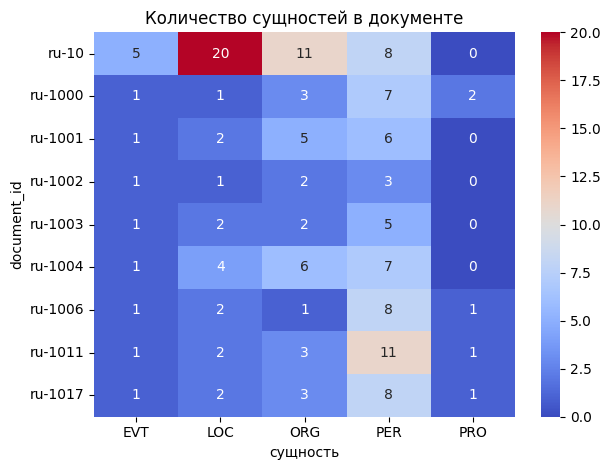

In [584]:
pivot_table = df_res_metrics.pivot_table(
    index='document_id', 
    columns='entity', 
    values='n_ent_gold'
    )

sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.title('Количество сущностей в документе')
plt.xlabel('сущность')
plt.ylabel('document_id')
plt.tight_layout()
plt.show()

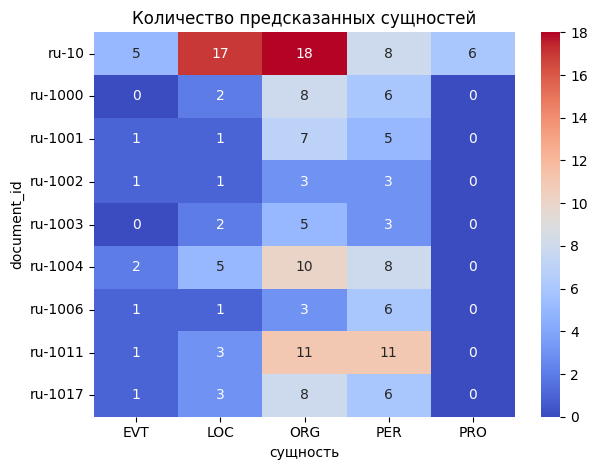

In [585]:
pivot_table = df_res_metrics.pivot_table(
    index='document_id', 
    columns='entity', 
    values='n_ent_pred'
    )

sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.title('Количество предсказанных сущностей')
plt.xlabel('сущность')
plt.ylabel('document_id')
plt.tight_layout()
plt.show()

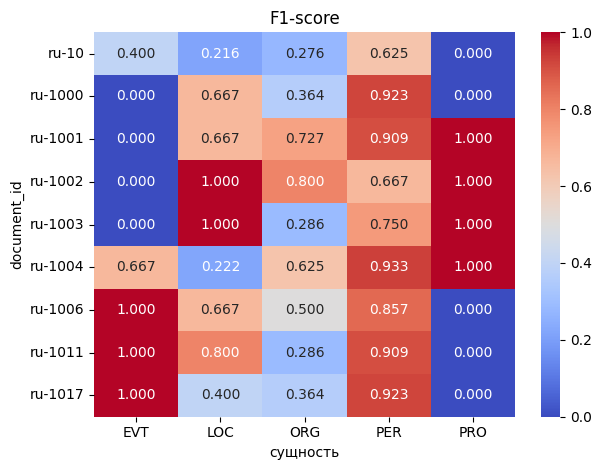

In [586]:
pivot_table = df_res_metrics.pivot_table(
    index='document_id', 
    columns='entity', 
    values='f1'
    )

sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='coolwarm')
plt.title('F1-score')
plt.xlabel('сущность')
plt.ylabel('document_id')
plt.tight_layout()
plt.show()

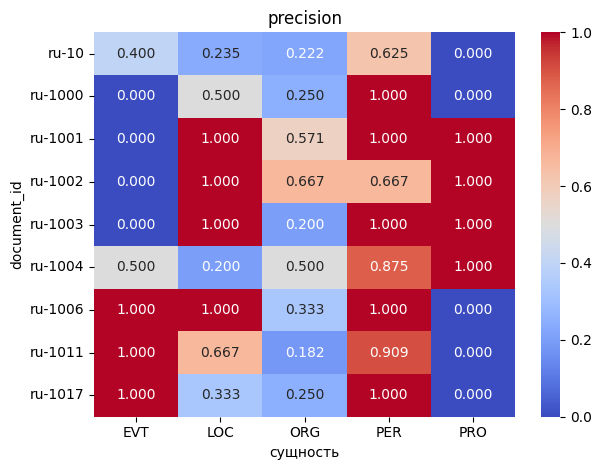

In [587]:
pivot_table = df_res_metrics.pivot_table(
    index='document_id', 
    columns='entity', 
    values='precision'
    )

sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='coolwarm')
plt.title('precision')
plt.xlabel('сущность')
plt.ylabel('document_id')
plt.tight_layout()
plt.show()

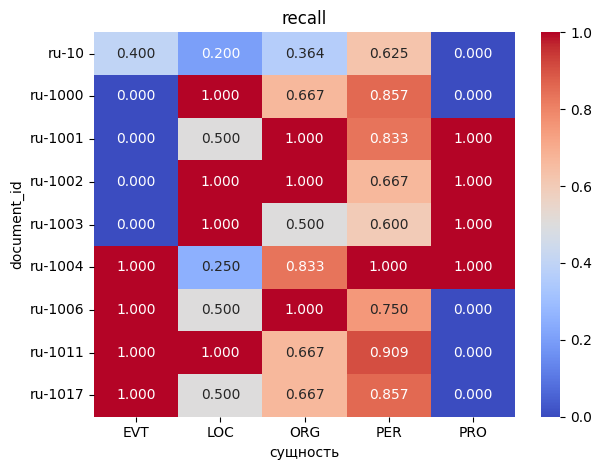

In [588]:
pivot_table = df_res_metrics.pivot_table(
    index='document_id', 
    columns='entity', 
    values='recall'
    )

sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='coolwarm')
plt.title('recall')
plt.xlabel('сущность')
plt.ylabel('document_id')
plt.tight_layout()
plt.show()

In [589]:
df_res_entity = df_res_metrics.groupby('entity').mean('f1')[['f1', 'precision', 'recall']]
df_res_entity

,f1,precision,recall
entity,,,
EVT,0.451852,0.433333,0.488889
LOC,0.626493,0.659477,0.661111
ORG,0.469648,0.352830,0.744108
PER,0.832942,0.897306,0.788709
PRO,0.444444,0.444444,0.444444


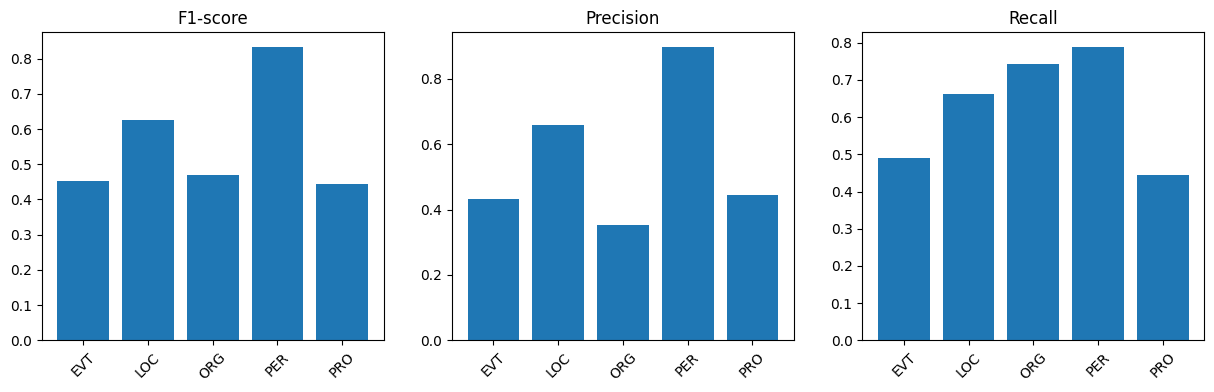

In [636]:
fig, ax = plt.subplots(figsize=(15, 4), ncols=3, nrows=1)

ax[0].bar(df_res_entity.index, df_res_entity['f1'])
ax[1].bar(df_res_entity.index, df_res_entity['precision'])
ax[2].bar(df_res_entity.index, df_res_entity['recall'])

ax[0].set_title('F1-score')
ax[1].set_title('Precision')
ax[2].set_title('Recall')

for a in ax:
    a.tick_params(axis='x', rotation=45)

plt.show()

Лучше всего в среднем модель распознает сущности типа LOC (f1=0.83), а PRO и EVT распознаются в среднем хуже остальных классов (f1 равен 0.44 и 0.45 соответственно). У ORG очень низкий precision (0.35), то есть модель часто в эту категорию относит много лишних сущностей.

In [637]:
df_res_doc = df_res_metrics.groupby('document_id').mean('f1')[['f1', 'precision', 'recall']]
df_res_doc

,f1,precision,recall
document_id,,,
ru-10,0.303416,0.296503,0.317727
ru-1000,0.390676,0.350000,0.504762
ru-1001,0.660606,0.714286,0.666667
ru-1002,0.693333,0.666667,0.733333
ru-1003,0.607143,0.640000,0.620000
ru-1004,0.689444,0.615000,0.816667
ru-1006,0.604762,0.666667,0.650000
ru-1011,0.598961,0.551515,0.715152
ru-1017,0.537343,0.516667,0.604762


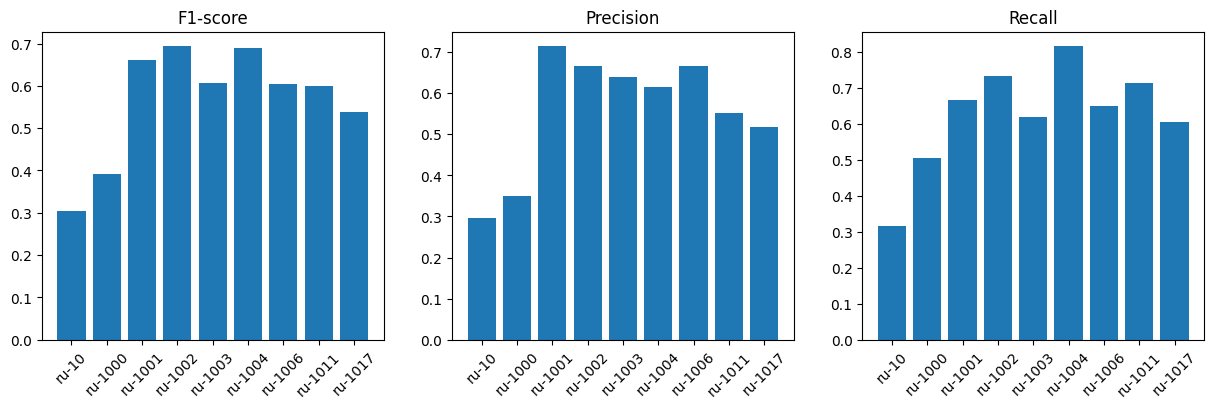

In [638]:
fig, ax = plt.subplots(figsize=(15, 4), ncols=3, nrows=1)

ax[0].bar(df_res_doc.index, df_res_doc['f1'])
ax[1].bar(df_res_doc.index, df_res_doc['precision'])
ax[2].bar(df_res_doc.index, df_res_doc['recall'])

ax[0].set_title('F1-score')
ax[1].set_title('Precision')
ax[2].set_title('Recall')

for a in ax:
    a.tick_params(axis='x', rotation=45)

plt.show()

Самый низкие метрики по всем классам в среднем у документа ru-10 (это самый длинный документ). У документа ru-1000 также невысокие показатели (precision=0.35, recall=0.5). Для остальных документов метрики достаточно неплохие.

Более подробно метрики и ошибки модели рассмотрены в задание 8

In [593]:
df_res_doc['document_id'] = df_res_doc.index
df_res_doc.index = np.arange(len(df_res_doc))
df_res_doc

,f1,precision,recall,document_id
0,0.303416,0.296503,0.317727,ru-10
1,0.390676,0.350000,0.504762,ru-1000
2,0.660606,0.714286,0.666667,ru-1001
3,0.693333,0.666667,0.733333,ru-1002
4,0.607143,0.640000,0.620000,ru-1003
5,0.689444,0.615000,0.816667,ru-1004
6,0.604762,0.666667,0.650000,ru-1006
7,0.598961,0.551515,0.715152,ru-1011
8,0.537343,0.516667,0.604762,ru-1017


Создадим итоговую таблицу с длинами документов:

In [594]:
df_res = df_res.merge(df_res_doc)
df_res

,document_id,gold_answer,pred,doc_len,f1,precision,recall
0,ru-10,[Brexit|EVT]; [Альбиона|LOC]; [Альбионе|LOC]; ...,"[""брекзит""|EVT]; [Brexit|EVT]; [Австрия|LOC]; ...",5157,0.303416,0.296503,0.317727
1,ru-1006,[Brexit|EVT]; [Facebook|PRO]; [Борис Джонсон|P...,[Brexit|EVT]; [Facebook|ORG]; [Борис Джонсон|P...,839,0.604762,0.666667,0.650000
2,ru-1004,[Brexit|EVT]; [Борис Джонсон|PER]; [Германии|L...,[Brexit|EVT]; [Борис Джонсон|PER]; [Германия|L...,1086,0.689444,0.615000,0.816667
3,ru-1011,[Brexit|EVT]; [The Guardian|PRO]; [Борис Джонс...,[29 марта|DATE]; [Brexit|EVT]; [ES|ORG]; [The ...,1641,0.598961,0.551515,0.715152
4,ru-1001,[Associated Press|ORG]; [Brexit|EVT]; [Борис Д...,[Associated Press|ORG]; [Борис Джонсон|PER]; [...,689,0.660606,0.714286,0.666667
5,ru-1000,[Brexit|EVT]; [The Guardian|PRO]; [Борис Джонс...,[The Guardian|ORG]; [ua|ORG]; [Борис Джонсон|P...,878,0.390676,0.350000,0.504762
6,ru-1002,[Бориса Джонсона|PER]; [Брекзит|EVT]; [Великоб...,[09.07.2018 18:09|DATE]; [«Брекзит»|EVT]; [Бор...,435,0.693333,0.666667,0.733333
7,ru-1017,[Brexit|EVT]; [The Guardian|PRO]; [Борис Джонс...,[9 июля|DATE]; [Brexit|EVT]; [The Guardian|ORG...,955,0.537343,0.516667,0.604762
8,ru-1003,[Борис Джонсон|PER]; [Великобритании|LOC]; [Да...,[09.07.2018 17:02|DATE]; [Борис Джонсон|PER]; ...,491,0.607143,0.640000,0.620000


### Задание 7

Есть ли зависимость метрик от длины документа? Постройте графики, чтобы ответить на вопрос.

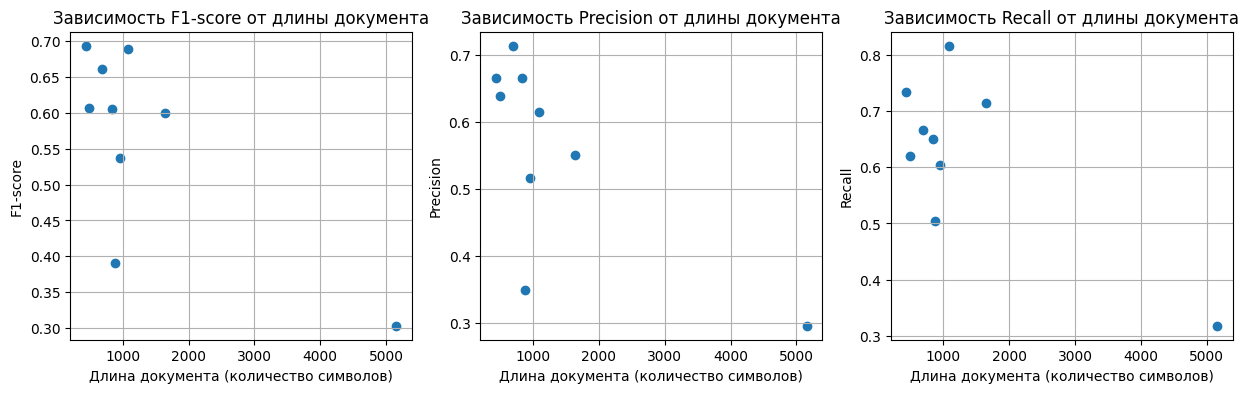

In [661]:
fig, ax = plt.subplots(figsize=(15, 4), ncols=3, nrows=1)

ax[0].scatter(df_res['doc_len'], df_res['f1'])
ax[0].grid()
ax[0].set_xlabel('Длина документа (количество символов)')
ax[0].set_ylabel('F1-score')
ax[0].set_title('Зависимость F1-score от длины документа')

ax[1].scatter(df_res['doc_len'], df_res['precision'])
ax[1].grid()
ax[1].set_xlabel('Длина документа (количество символов)')
ax[1].set_ylabel('Precision')
ax[1].set_title('Зависимость Precision от длины документа')

ax[2].scatter(df_res['doc_len'], df_res['recall'])
ax[2].grid()
ax[2].set_xlabel('Длина документа (количество символов)')
ax[2].set_ylabel('Recall')
ax[2].set_title('Зависимость Recall от длины документа')
plt.show()

In [605]:
df_res_metrics.head()

,document_id,entity,n_ent_gold,n_ent_pred,gold_answer,pred_answer,f1,precision,recall
0,ru-10,PER,8,8,[Борис Джонсон|PER]; [Джонсон|PER]; [Джонсона|...,[Борис Джонсон|PER]; [Джонсон|PER]; [Джонсона|...,0.625000,0.625000,0.625000
1,ru-10,ORG,11,18,[ЕС|ORG]; [Еврокомиссия|ORG]; [Европейскому|OR...,[ЕС|ORG]; [Еврокомиссия|ORG]; [Европейский сою...,0.275862,0.222222,0.363636
2,ru-10,LOC,20,17,[Альбиона|LOC]; [Альбионе|LOC]; [Британии|LOC]...,[Австрия|LOC]; [Альбион|LOC]; [Брюссель|LOC]; ...,0.216216,0.235294,0.200000
3,ru-10,EVT,5,5,[Brexit|EVT]; [брекзит|EVT]; [брекзита|EVT]; [...,"[""брекзит""|EVT]; [Brexit|EVT]; [брекзит|EVT]; ...",0.400000,0.400000,0.400000
4,ru-10,PRO,0,6,,[британская конституция|PRO]; [будущее|PRO]; [...,0.000000,0.000000,0.000000


In [616]:
df_res_metrics[df_res_metrics.entity == 'PER'][['document_id', 'f1']]

,document_id,f1
0,ru-10,0.625000
5,ru-1006,0.857143
10,ru-1004,0.933333
15,ru-1011,0.909091
20,ru-1001,0.909091
25,ru-1000,0.923077
30,ru-1002,0.666667
35,ru-1017,0.923077
40,ru-1003,0.750000


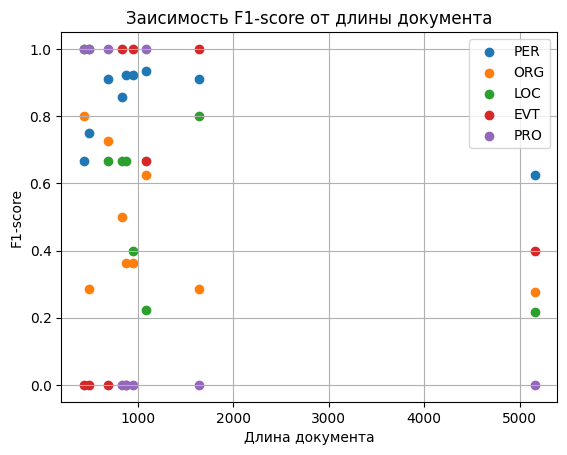

In [626]:
f1_all_entities = {ent_type: df_res_metrics[df_res_metrics.entity == ent_type]['f1'].values for ent_type in entity_types}
recall_all_entities = {ent_type: df_res_metrics[df_res_metrics.entity == ent_type]['recall'].values for ent_type in entity_types}
precision_all_entities = {ent_type: df_res_metrics[df_res_metrics.entity == ent_type]['precision'].values for ent_type in entity_types}

for k, v in f1_all_entities.items():
    plt.scatter(df_res['doc_len'], v, label=k)

plt.title('Заисимость F1-score от длины документа')
plt.xlabel('Длина документа')
plt.ylabel('F1-score')
plt.grid()
plt.legend()
plt.show()

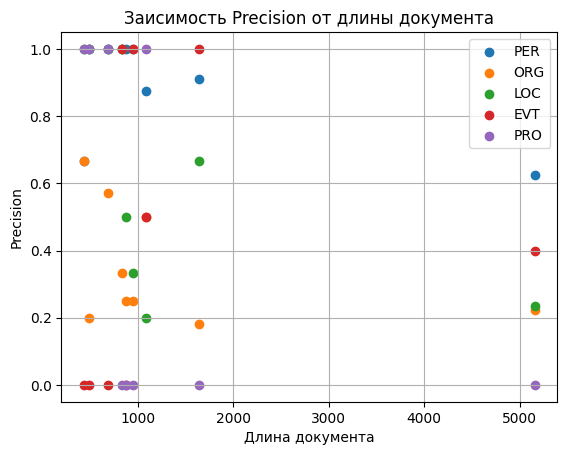

In [627]:
for k, v in precision_all_entities.items():
    plt.scatter(df_res['doc_len'], v, label=k)

plt.title('Заисимость Precision от длины документа')
plt.xlabel('Длина документа')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()

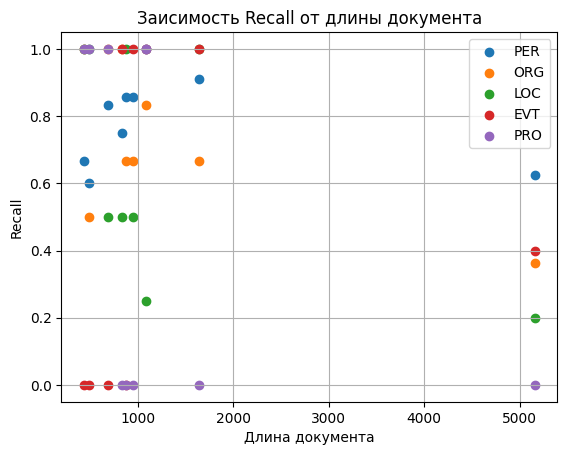

In [628]:
for k, v in recall_all_entities.items():
    plt.scatter(df_res['doc_len'], v, label=k)

plt.title('Заисимость Recall от длины документа')
plt.xlabel('Длина документа')
plt.ylabel('Recall')
plt.grid()
plt.legend()
plt.show()

Для самого длинного документа с идентификатором ru-10 метрики значительно ниже чем для остальных документов. Только класс PER определяется относительно неплохо во всех текстах вне зависимости от их длины.

В остальных случая явная зависимость не прослеживается, но и тексты несильно отличаются друг от друга по количеству символов и количеству сущностей разных классов.

### Задание 8

Проведите анализ ошибок. Когда модель чаще отвечает правильно, а когда ошибается? Предложите варианты, как повысить метрики.

In [655]:
print('gold: ' + df_res_metrics[df_res_metrics['entity'] == 'PER'].gold_answer.iloc[5])
print('pred: ' + df_res_metrics[df_res_metrics['entity'] == 'PER'].pred_answer.iloc[5])
print()
print('gold: ' + df_res_metrics[df_res_metrics['entity'] == 'PER'].gold_answer.iloc[-1])
print('pred: ' + df_res_metrics[df_res_metrics['entity'] == 'PER'].pred_answer.iloc[-1])

gold: [Борис Джонсон|PER]; [Бориса Джонсона|PER]; [Бориса|PER]; [Джонсон|PER]; [Дэвид Дэвис|PER]; [Стив Бейкер|PER]; [Тереза Мэй|PER]
pred: [Борис Джонсон|PER]; [Бориса Джонсона|PER]; [Джонсон|PER]; [Дэвид Дэвис|PER]; [Стив Бейкер|PER]; [Тереза Мэй|PER]

gold: [Борис Джонсон|PER]; [Джонсона|PER]; [Дэвид Дэвис|PER]; [Мэй|PER]; [Тереза Мэй|PER]
pred: [Борис Джонсон|PER]; [Дэвид Дэвис|PER]; [Тереза Мэй|PER]


Лучше всего модель распознает сущности типа PER (люди). При этом precision значительно выше чем recall и равен 1 практически для всех документов. То есть модель редко относит к классу PER сущности, которые не являются людьми, однако в документах есть "люди", которые модель не относит к соответстующей категории. Так, из примера видно, что у модели не очень хорошо получается распознавать имена без фамилий.

Но стоит учитывать, что сущностей, которые относятся к этой категории в принципе больше чем всех остальных сущностей. 

In [657]:
print('gold: ' + df_res_metrics[df_res_metrics['entity'] == 'PRO'].gold_answer.iloc[5])
print('pred: ' + df_res_metrics[df_res_metrics['entity'] == 'PRO'].pred_answer.iloc[5])
print()
print('gold: ' + df_res_metrics[df_res_metrics['entity'] == 'PRO'].gold_answer.iloc[-1])
print('pred: ' + df_res_metrics[df_res_metrics['entity'] == 'PRO'].pred_answer.iloc[-1])
print()
print('gold: ' + df_res_metrics[df_res_metrics['entity'] == 'PRO'].gold_answer.iloc[0])
print('pred: ' + df_res_metrics[df_res_metrics['entity'] == 'PRO'].pred_answer.iloc[0])

gold: [The Guardian|PRO]; [Подробности.ua|PRO]
pred: 

gold: 
pred: 

gold: 
pred: [британская конституция|PRO]; [будущее|PRO]; [европейские законы|PRO]; [лекарственные препараты|PRO]; [политическое|PRO]; [экономическое|PRO]


У модели плохо получается распознавать класс PRO. Модель "избегает" этот класс и практически не относит к нему никакие сущности (а если относит, то с ошибками). В принципе в документах мало сущностей типа PRO, поэтому F1-score не слишком низкий. Чтобы сделать более объективные выводы об этом классе, нужно рассмотреть больше данных 

In [658]:
print('gold: ' + df_res_metrics[df_res_metrics['entity'] == 'ORG'].gold_answer.iloc[5])
print('pred: ' + df_res_metrics[df_res_metrics['entity'] == 'ORG'].pred_answer.iloc[5])
print()
print('gold: ' + df_res_metrics[df_res_metrics['entity'] == 'ORG'].gold_answer.iloc[-1])
print('pred: ' + df_res_metrics[df_res_metrics['entity'] == 'ORG'].pred_answer.iloc[-1])
print()
print('gold: ' + df_res_metrics[df_res_metrics['entity'] == 'ORG'].gold_answer.iloc[0])
print('pred: ' + df_res_metrics[df_res_metrics['entity'] == 'ORG'].pred_answer.iloc[0])

gold: [ЕС|ORG]; [МИД Соединенного Королевства|ORG]; [УНН|ORG]
pred: [The Guardian|ORG]; [ua|ORG]; [ЕС|ORG]; [МИД|ORG]; [УНН|ORG]; [министра иностранных дел|ORG]; [премьер-министр|ORG]; [пресс-секретарь британского парламента|ORG]

gold: [Евросоюза|ORG]; [Рейтер|ORG]
pred: [Евросоюза|ORG]; [агентство Рейтер|ORG]; [министр иностранных дел Великобритании|ORG]; [министр по вопросам брекзита|ORG]; [премьер|ORG]

gold: [ЕС|ORG]; [Еврокомиссия|ORG]; [Европейскому|ORG]; [Евросоюза|ORG]; [Евросоюзом|ORG]; [Консервативной партии|ORG]; [Международного валютного фонда|ORG]; [британском парламенте|ORG]; [британскому парламентам|ORG]; [лейбористы|ORG]; [тори|ORG]
pred: [ЕС|ORG]; [Еврокомиссия|ORG]; [Европейский союз|ORG]; [Европейскому парламенту|ORG]; [Евросоюз|ORG]; [Международный валютный фонд|ORG]; [СМИ|ORG]; [бизнес|ORG]; [британским парламентом|ORG]; [британском парламенте|ORG]; [британскому парламенту|ORG]; [бывший министр иностранных дел|ORG]; [лейбористы|ORG]; [министр иностранных дел Брита

Для класса ORG высокий recall, но низкий precision, то есть модель в принципе неплохо распознает организация, но относит к этой категории много лишнего.

In [660]:
print('gold: ' + df_res_metrics[df_res_metrics['entity'] == 'EVT'].gold_answer.iloc[5])
print('pred: ' + df_res_metrics[df_res_metrics['entity'] == 'EVT'].pred_answer.iloc[5])
print()
print('gold: ' + df_res_metrics[df_res_metrics['entity'] == 'EVT'].gold_answer.iloc[-1])
print('pred: ' + df_res_metrics[df_res_metrics['entity'] == 'EVT'].pred_answer.iloc[-1])
print()
print('gold: ' + df_res_metrics[df_res_metrics['entity'] == 'EVT'].gold_answer.iloc[0])
print('pred: ' + df_res_metrics[df_res_metrics['entity'] == 'EVT'].pred_answer.iloc[0])

gold: [Brexit|EVT]
pred: 

gold: [брекзита|EVT]
pred: 

gold: [Brexit|EVT]; [брекзит|EVT]; [брекзита|EVT]; [брекзиту|EVT]; [брексит|EVT]
pred: ["брекзит"|EVT]; [Brexit|EVT]; [брекзит|EVT]; [саммит|EVT]; [экстренного саммита Европейского союза|EVT]


Сложно сделать вывод о EVT, так как в документах совсем немного сущностей этого класса (почти во всех документах по 1 сущности этого класса). Иногда модель угадывает, иногда нет. В целом можно заметить, что модель плохо распознает формы слов (кроме начальной формы)

In [659]:
print('gold: ' + df_res_metrics[df_res_metrics['entity'] == 'LOC'].gold_answer.iloc[5])
print('pred: ' + df_res_metrics[df_res_metrics['entity'] == 'LOC'].pred_answer.iloc[5])
print()
print('gold: ' + df_res_metrics[df_res_metrics['entity'] == 'LOC'].gold_answer.iloc[-1])
print('pred: ' + df_res_metrics[df_res_metrics['entity'] == 'LOC'].pred_answer.iloc[-1])
print()
print('gold: ' + df_res_metrics[df_res_metrics['entity'] == 'LOC'].gold_answer.iloc[0])
print('pred: ' + df_res_metrics[df_res_metrics['entity'] == 'LOC'].pred_answer.iloc[0])

gold: [Великобритании|LOC]
pred: [Великобритании|LOC]; [Соединенного Королевства|LOC]

gold: [Великобритании|LOC]; [Даунинг-Стрит|LOC]
pred: [Великобритании|LOC]; [Даунинг-Стрит|LOC]

gold: [Альбиона|LOC]; [Альбионе|LOC]; [Британии|LOC]; [Британия|LOC]; [Брюсселе|LOC]; [Брюсселем|LOC]; [Брюссель|LOC]; [Брюсселю|LOC]; [Брюсселя|LOC]; [Европа|LOC]; [Европе|LOC]; [Европой|LOC]; [Европы|LOC]; [Ла-Манша|LOC]; [Лондон|LOC]; [Лондона|LOC]; [Лондоне|LOC]; [Лондону|LOC]; [Северную Ирландию|LOC]; [Соединенного Королевства|LOC]
pred: [Австрия|LOC]; [Альбион|LOC]; [Брюссель|LOC]; [Великобритания|LOC]; [Европейской|LOC]; [Европы|LOC]; [Ла-Манш|LOC]; [Лондон|LOC]; [Лондоном|LOC]; [Северную Ирландию|LOC]; [Соединенное Королевство|LOC]; [единой Европы|LOC]; [колонией|LOC]; [сентября|LOC]; [страны|LOC]; [территории|LOC]; [финансовых рынках|LOC]


Класс LOC модель определяет через раз, но в текстах в принципе этот класс встречается нечасто. В самом длинном документе модель допустила много ошибок. Модель автоматически приводит сущности к начальной форме и в некоторых случаях пропускает все формы кроме начальной.  

Способы улучшить метрики:

1. Доработать промпт. Можно более подробно расписать, что из себя представляет каждая из категорий. Также в промпте можно прописать пример из проблемных кейсов. Возможно, это позволит модели замечать не только base form, но и другие формы. Также в промпте стоит прописать, какие сущности не относятся к каждой из категорий. Это может в частности повысить precision для ORG (модель часто относит к этой категории органы власти и названия должностей)
2. Использовать больше данных. Некоторые сущности редко встречаются в документах, поэтому оценка качества для таких классов не совсем объективная.
3. Использовать другую LLM. Возможно, другие LLM дадут более высокие результаты
4. Использовать гибридный подход. У модели вызывает трудности класс PRO. Можно было бы составить базу данных с названиями продуктов, которые часто упоминаются в новостях, чтобы модель их не пропускала.


### Задание 9

Сделайте выводы по всему исследованию. Напишите, чему научились и что нового попробовали.


Итак, удалось идентифицировать и классифицировать большую часть именованных сущностей из предложенного датасета. В ходе исследования также была дана оценка качества модели на основе метрик f1, recall, precision. Были выявлены случаи, в которых модель ошибается чаще всего, а также были предложены возможные способы улучшения метрик. 

В ходе работы я разобралась в сути задачи NER, а также узнала возможные способы ее решения. Также впервые использовала LLM для решения NLP задачи. Кроме того, я многое узнала о векторизованных функциях и принципе работы np.vectorize.